In [1]:
# We will create a neural network without additional modules. 
# We will use this to predict the next numbers in a sin wave. 

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np


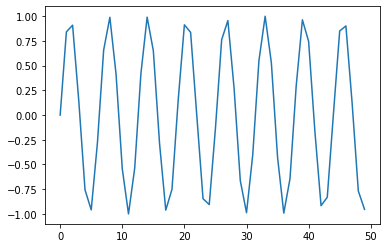

In [3]:
sin_wave = np.array([math.sin(x) for x in np.arange(200)])
plt.plot(sin_wave[:50])

In [4]:
# We will need to convert each data point to a point in our array. We will use whole numbers and use the following code block to create our train_set. 

In [5]:
X = []
Y = []

seq_len = 50
num_records = len(sin_wave) - seq_len

for i in range(num_records - 50):
    X.append(sin_wave[i:i+seq_len])
    Y.append(sin_wave[i+seq_len])

X = np.array(X)
X = np.expand_dims(X, axis=2)

Y = np.array(Y)
Y = np.expand_dims(Y, axis = 1)

In [6]:
print(X.shape, Y.shape)

(100, 50, 1) (100, 1)


In [7]:
# We set aside 50 records for our validation set, and we will initialize that set here.

In [8]:
X_val = []
Y_val = []

for i in range(num_records - 50, num_records):
    X_val.append(sin_wave[i:i+seq_len])
    Y_val.append(sin_wave[i+seq_len])
    
X_val = np.array(X_val)
X_val = np.expand_dims(X_val, axis = 2)

Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis = 1)

In [9]:
print(X_val.shape, Y_val.shape)

(50, 50, 1) (50, 1)


In [10]:
# Now that we have the train and validation data we can move onto creating the network. 

In [11]:
# Series of variables that we will use in our network.

In [32]:
learning_rate = 0.00001
nepoch = 10
T = 50       # This is the length of the sequence we train on. 
hidden_dim = 100
output_dim = 1

bptt_truncate = 5
min_clip_value = -10
max_clip_value = 10


In [13]:
# We will set the wights of our matrix.

In [14]:
U = np.random.uniform(0, 1, (hidden_dim, T))
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))
V = np.random.uniform(0, 1, (output_dim, hidden_dim))

In [15]:
# Define an activation function

In [16]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [17]:
# We need to manually do our forward pass and backpropogate the error. 

In [18]:
# forward pass and squared error for predictions to get loss value. 


In [33]:
for epoch in range(nepoch):
    #checking our loss on our training data
    loss = 0.0
    
    # one forward pass for prediction
    for i in range(Y.shape[0]):
        #get input and output values for each record
        x, y = X[i], Y[i]
        # prev_s is the value of the previous activation of a hidden layer. it initializes as zero. 
        prev_s = np.zeros((hidden_dim, 1))
        for t in range(T):
            # This is a loop is a forward pass for every timestep in the sequence
            new_input = np.zeros(x.shape)
            # This defines a single input for each time step.
            new_input[t] = x[t]
            # This uses our weights to calculate outcomes. 
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s
        # After the loop we now calculate our error.    
        loss_per_record = (y - mulv)**2 / 2
        loss += loss_per_record
        
    loss = loss / float(y.shape[0])
    
    # Now we need to check vs our validation data. This is the same process as the previous forward pass
    val_loss = 0.0
    for i in range(Y_val.shape[0]):
        x, y = X_val[i], Y_val[i]
        prev_s = np.zeros((hidden_dim, 1))
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s
        loss_per_record = (y - mulv)**2 / 2
        val_loss += loss_per_record
    val_loss = val_loss / float(y.shape[0])
    
    print('Epoch:', epoch + 1, ', Loss: ', loss, ', Val Loss:', val_loss)
    
    #We need to start training our actual model 
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]
        # initialization of parameters
        layers = []
        prev_s = np.zeros((hidden_dim, 1))
        
        dU = np.zeros(U.shape)
        dV = np.zeros(V.shape)
        dW = np.zeros(W.shape)
        
        dU_t = np.zeros(U.shape)
        dV_t = np.zeros(V.shape)
        dW_t = np.zeros(W.shape)
        
        dU_i = np.zeros(U.shape)
        dW_i = np.zeros(W.shape)
        
        # Forward pass
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            layers.append({'s':s, 'prev_s':prev_s})
            prev_s = s      
        # We need to back propogate the errors now. 
        dmulv = (mulv - y)
        for t in range(T):
            dV_t = np.dot(dmulv, np.transpose(layers[t]['s']))
            dsv = np.dot(np.transpose(V), dmulv)
            
            ds = dsv
            dadd = add * (1 - add) * ds
            
            dmulw = dadd * np.ones_like(mulw)
            
            dprev_s = np.dot(np.transpose(W), dmulw)
            
            for i in range(t-1, max(-1, t - bptt_truncate - 1), -1):
                ds = dsv + dprev_s
                dadd = add * (1 - add) * ds
                
                dmulw = dadd * np.ones_like(mulw)
                dmulu = dadd * np.ones_like(mulu)
                
                dW_i = np.dot(W, layers[t]['prev_s'])
                dprev_s = np.dot(np.transpose(W), dmulw)
                
                new_input = np.zeros(x.shape)
                new_input[t] = x[t]
                dU_i = np.dot(U, new_input)
                dx = np.dot(np.transpose(U), dmulu)
                
                dU_t += dU_i
                dW_t += dW_i         
                
            dV += dV_t
            dU += dU_t
            dW += dW_t
        
            # We need to now update weights with the gradients. We have to prevent exploding gradients, so we will clamp a range. 
            if dU.max() > max_clip_value:
                dU[dU > max_clip_value] = max_clip_value
            if dV.max() > max_clip_value:
                dV[dV > max_clip_value] = max_clip_value
            if dW.max() > max_clip_value:
                dW[dW > max_clip_value] = max_clip_value
                
            if dU.min() < min_clip_value:
                dU[dU < min_clip_value] = min_clip_value
            if dV.min() < min_clip_value:
                dV[dV < min_clip_value] = min_clip_value
            if dV.min() < min_clip_value:
                dV[dV < min_clip_value] = min_clip_value
          
             
        # updates
        U -= learning_rate * dU
        V -= learning_rate * dV
        W -= learning_rate * dW
        
        

Epoch: 1 , Loss:  [[29.07822481]] , Val Loss: [[14.51134176]]
Epoch: 2 , Loss:  [[29.08062353]] , Val Loss: [[14.51331069]]
Epoch: 3 , Loss:  [[28.88097369]] , Val Loss: [[14.41387426]]
Epoch: 4 , Loss:  [[29.08375146]] , Val Loss: [[14.51326786]]
Epoch: 5 , Loss:  [[29.37650104]] , Val Loss: [[14.65923392]]
Epoch: 6 , Loss:  [[29.27120534]] , Val Loss: [[14.60576192]]
Epoch: 7 , Loss:  [[28.52340126]] , Val Loss: [[14.23841923]]
Epoch: 8 , Loss:  [[29.16588522]] , Val Loss: [[14.55448698]]
Epoch: 9 , Loss:  [[28.73134167]] , Val Loss: [[14.34036253]]
Epoch: 10 , Loss:  [[29.03383802]] , Val Loss: [[14.48952937]]


In [20]:
#Now that our model is trained, let's use it for predictions. 

In [34]:
preds = []
for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    prev_s = np.zeros((hidden_dim, 1))
    # Forward pass
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)
# preds = []
# for i in range(Y.shape[0]):
#     x, y = X[i], Y[i]
#     prev_s = np.zeros((hidden_dim, 1))
#     # forward pass
#     for t in range(T):
#         mulu = np.dot(U, x)
#         mulw = np.dot(W, prev_s)
#         add = mulw + mulu
#         s = sigmoid(add)
#         mulv = np.dot(V, s)
#         prev_s = s
        
#     preds.append(mulv)
    
# preds = np.array(preds)

In [22]:
# lets plot our predictions and see what we get. 

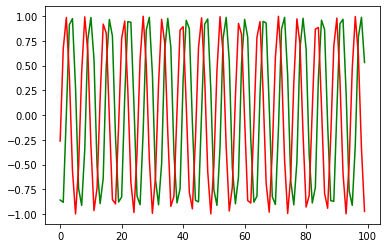

In [35]:
plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y[:, 0], 'r')
plt.show()

In [24]:
# Test for overfitting

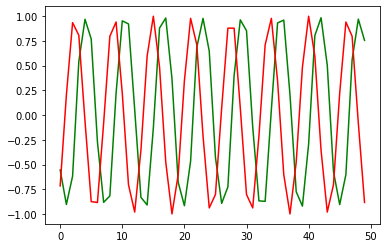

In [31]:
preds = []
for i in range(Y_val.shape[0]):
    x, y = X_val[i], Y_val[i]
    prev_s = np.zeros((hidden_dim, 1))
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s
        
    preds.append(mulv)
    
preds = np.array(preds)

plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y_val[:, 0], 'r')
plt.show()


In [26]:
# We have a rough sine wave prediction, however it is out of sync with our data. Our model is no decreasing the loss further so we would need to add another layer or add more nodes to be able to tune it better. 


NameError: name 'max_val' is not defined